# Unemployment rate in SA

In [1]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import RFE
from sklearn import metrics
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.metrics import r2_score
from sklearn import preprocessing
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats
from statsmodels.formula.api import rlm
import statsmodels.api as sm
from sklearn.utils import resample
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import mean_squared_error
import re
import string

The purpose of this notebook is to explore variables that could potetially have a relationship with our response variables, i.e unemployment rate.


Government has published a 25-year ‘review’ focusing on the progress made by South Africa since democracy in 1994 in areas such as unemployment. Citing data from Stats SA, the review shows that 8.9 million people were employed in 1994, with an unemployment rate of 20%. However, it should be noted that the unemployment rate at that time did not include the Bantustans and the black majority. In 1994, there were 41 million South Africans, therefore the employed represented 21% of the population. By the end of 2018, the number of people employed had almost doubled to 16.5 million people, representing 28.5% of the population. Despite this, and as a consequence of an increasing population growth which surpassed the economic growth, the unemployment rate has increased to 27.1%.
This unemployment rate has continued to climb in 2019, reaching 29.1% in the third quarter – its highest rate in over 16 years. The country’s unemployment rate last reached 28% in 2003.
https://businesstech.co.za/news/business/353051/south-africa-unemployment-1994-vs-2019/

We will first start of by exploring which varibles have a relationship with the unemployment rate then after use those variables to answer the following questions:

Questions:

1. How does the government cash flow affect unemployment rate? <br>
decribe
2. Do investment returns affect the employment rate?<br>
decribe

3. How does the government assets affect unemployment rate?<br>
decribe

4. How does the government debt affect unemployment rate?<br>



### Methodology
**Draft**
Since we are investigating the cause and effect relationship of unemployment in South Africa using unemployement database which consists of variables which cover a significant portfion of the South African economy. The databse was obtained from South African Reserve Bank website. The aim is to conduct an investigation using the time period of 1994 to 2020. <br/>

#### Methods of of analysis
**Draft**
Since analysis will be based on quantitavive data, we prepared the data using a software called SPSS to analyse our data. Before the analysis, the dataset was checked for missing data. The data was further analyzed using statistical graphs. An F-test is then used to test our hypothesis.<br/>


Section of Contents:
- Data Description
- Data Collection
- Data Preparation
- Empirical Analysis
- Model Fitting
- Hypothesis Testing
- Interpretation of Results
- Conclusion


# Data Description

The data was accessed
from the South African Reserve Bank (SARB). The SARB mostly collects and reports its
own data, however, a few features are sourced from Statistics South Africa. Therefore, this
data is reliable and the data generating process is transparent and accessible on the SARB
website: this refered to as the Special Data Dissemination Standard (SDDS). The data has
coverage of a number of key economic sectors in South Africa: real, fiscal, financial, and
external sector as well as population data.
It is also work noting that economic data is typically available in constant prices or current prices. Constant prices are prices as at a given date, therefore, the value today is not
affected by economic changes that would not make a non-financial difference to it. For example inflation causes prices to change, not because anything has changed about the goods
or services but because time has passed. Current prices are those that incorporate these
financial changes such as inflation. For this research we elected to use constant prices to
avoid inflation being a confounding variable across across our data. Inflation (CPI) is itself
a feature that was used for this research. <br>


* Collection method:  **draft**
* Date collected: April 16, 2015
* Date Downloaded: April 07, 2021
* Data size: 1432 rows, 147 columns

## Validation of the data
## Aspects of Data Quality 
## Ability to Answer Question

# Data Collection

### South African Reserve Bank Cleaned Economic Data

Data prepared for modelling from the South African Reserve Bank

This data can used for both regression and classification research questions i.e. forecast the unemployment rate.

The original data was sourced from https://www.resbank.co.za/en/home/what-we-do/statistics/releases/economic-and-financial-data-for-south-africa


### The full feature set
*These feature were accessed from the South African Reserve Bank.*

*There are **147 features in total**, these cover a significant portfion of the South African economy*

**The data from 1922-01-01 to 2020-01-01** if it used for unemployment forecasting, deleting redudant observations is helpful

## Reading data

In [2]:
feature_set_sarb = pd.read_csv('sarb_features_data.csv').set_index('Date') # reading in data
target = pd.read_csv('sarb_target_data.csv').set_index('Date')

In [3]:
feature_set_sarb.head() # displaying first 5 rows for exploratory varibales

,Final consumption expenditure by general government,Consolidated general government: Revenue,Foreign liabilities: Total portfolio investment,Foreign liabilities: Portfolio investment: Equity securities,Domestic output: All groups,Final consumption expenditure by households: Total,Gross fixed capital formation,SDDS - Financial derivative liabilities,Foreign liabilities: Portfolio investment: Debt securities,Change in inventories,...,Remuneration per worker in non-agricultural: Total,Consolidated general government: Non-financial assets - Net,Consolidated general government: Cash surplus / deficit,CPI Headline,Gross domestic expenditure,Net cash-flow from operating activities,Non-agricultural employment: Total,Consolidated general government: Expense,Residual item,unemployment rate
Date,,,,,,,,,,,,,,,,,,,,,
1922-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.6,NaN,NaN,NaN,NaN,NaN,NaN
1922-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.6,NaN,NaN,NaN,NaN,NaN,NaN
1922-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.6,NaN,NaN,NaN,NaN,NaN,NaN
1922-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.6,NaN,NaN,NaN,NaN,NaN,NaN
1922-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,0.6,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
target.head() # displaying first 5 rows for target variable

,unemployment rate
Date,
1922-01-01,NaN
1922-02-01,NaN
1922-03-01,NaN
1922-04-01,NaN
1922-05-01,NaN


# Data Preparation



## Imputation



In [5]:
# Data imputation strategy is foward fill i.e last know value imputation
# Economic data usually does not change that much from month to month.
x_values_ffill = feature_set_sarb.fillna(method='bfill')
x_values_ffill = feature_set_sarb.fillna(method='ffill')
y_values_ffill = target.fillna(method='bfill')
y_values_ffill = target.fillna(method='ffill')

In [6]:
# Remove all data points before unemployment rate data is available. Unemployment rate is my target variable.
valid_start = y_values_ffill.first_valid_index()
y_values_ffill = y_values_ffill[valid_start : ]
x_values_ffill = x_values_ffill[valid_start : ]

In [7]:
#We fill with NA here to avoid any features that might be NA i.e. insurance
x_values_ffill = x_values_ffill.fillna(feature_set_sarb.mean())
y_values_ffill = y_values_ffill.fillna(target.mean())
x_values_ffill.isna().sum()

Final consumption expenditure by general government             0
Consolidated general government: Revenue                        0
Foreign liabilities: Total portfolio investment                 0
Foreign liabilities: Portfolio investment: Equity securities    0
Domestic output: All groups                                     0
                                                               ..
Net cash-flow from operating activities                         0
Non-agricultural employment: Total                              0
Consolidated general government: Expense                        0
Residual item                                                   0
unemployment rate                                               0
Length: 148, dtype: int64

## Empirical Analysis

In [8]:
x_values_ffill.columns

Index(['Final consumption expenditure by general government ',
       'Consolidated general government: Revenue',
       'Foreign liabilities: Total portfolio investment ',
       'Foreign liabilities: Portfolio investment: Equity securities',
       'Domestic output: All groups ',
       'Final consumption expenditure by households: Total ',
       'Gross fixed capital formation ',
       'SDDS - Financial derivative liabilities',
       'Foreign liabilities: Portfolio investment: Debt securities',
       'Change in inventories ',
       ...
       'Remuneration per worker in non-agricultural: Total ',
       'Consolidated general government: Non-financial assets - Net',
       'Consolidated general government: Cash surplus / deficit',
       'CPI Headline ', 'Gross domestic expenditure ',
       'Net cash-flow from operating activities ',
       'Non-agricultural employment: Total ',
       'Consolidated general government: Expense', 'Residual item ',
       'unemployment rate'],
   

# Model fitting

## How does different economic factors affect Unemployment rate ?

The purpose of this notebook is to explore variables that could potetially have a relationship with our response variables, i.e unemployment rate.
<br>
<br>
We will first start of by exploring which varibles have a relationship with the unemployment rate then after use those variables to answer the following questions:
<br>
<br>
**Questions:**<br>
1. How does the government cash flow affect unemployment rate?
2. Do investment returns affect the employment rate?
3. How does the government assets affect unemployment rate?
4. How does the government debt affect unemployment rate?
<br>
<br>
We will explore this relationship using the regression slope test that has a regression line of the format:
<br>
$$
Y=\beta_{i} X \ for \ i = 0,1,2...m
$$
Where $X$ are the selected variables and $\beta_{i}$ are the respective coefficients.Thus, the **hypothesis** is as follows:
$$
\begin{array}{l}{\mathrm{H}_{\mathrm{0}} : \beta_{0}=\beta_{1}=...=\beta_{m}=0} \\ {\mathrm{H}_{\mathrm{1}} : \beta_{i} \neq 0 } \ for \ at \ least\ one \ i\end{array}
$$

<br>
<br>
We will be using the $F$-test to simultaneously check the significance of a number of regression coefficients.

# Helper functions

These functions are common throughout the entire 4 models. 

Forward selection typically begins with only an intercept. One tests the various variables that may be relevant, and the ‘best’ variable where “best” is determined by some pre-determined criteria—is added to the model.<br>
As the model continues to improve (per that same criteria) we continue the process, adding in one variable at a time and testing at each step. Once the model no longer improves with adding more variables, the process stops. <br>

The Linear model function below is designed by Forward selection using the R2 score for measurement. **(Fill in here)**

In [9]:
def model_fit(X,y):
    
    """Linear model designed by forward selection.

    Parameters:
    -----------
    X: pandas DataFrame with all possible predictors and response

    y: decimal values, containing target variable

    Returns:
    --------
    score_list: a list containing the R2 coefficients of determining statistical 
    measure of how well the regression predictions approximate the real data points
           
    optimum_no_features: Variables with the optimum features
    
    """
    
    #no of features
    feature_list=np.arange(1, len(X.columns))            
    high_score=0
    #Variable to store the optimum features
    optimum_no_featurcashes=0           
    score_list =[]
    for n in range(len(feature_list)):
        model = LinearRegression()
        rfe = RFE(model,feature_list[n])
        X_train_rfe = rfe.fit_transform(X,y)
        model.fit(X_train_rfe,y)
        # R2 score for measurement
        score = r2_score(y, model.predict(X_train_rfe))
        score_list.append(score)
        
        if n % 10 == 0:
            print(n,score)
            
        if(score>high_score):
            high_score = score  
            optimum_no_features = feature_list[n]
    return score_list, optimum_no_features 

A function for R squared coefficient line graph plot

In [10]:
  """.

    Parameters:
    -----------
    values: list,R squared coefficient values
    title : string, title of the R squared coefficient plot 
    x_label: string, x-axis label
    y_label : string, y-axis label
    
    """

def plt_plot(values,title, x_label, y_label):
    
    plt.plot(values)
    plt.title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)

In [11]:
   """Linear model designed by forward selection.

    Parameters:
    -----------
    optimum_no_features: pandas DataFrame with all possible predictors and response

    X_train: decimal values, containing target variable
    y_train:
    
    Returns:
    --------
    score_list: a list containing the R2 coefficients of determining statistical 
    measure of how well the regression predictions approximate the real data points
           
    optimum_no_features: Variables with the optimum features
    
    """



def final_model(optimum_no_features, X_train, y_train,cols):
    model = LinearRegression()
    #Initializing RFE model
    rfe = RFE(model, optimum_no_features)             
    #Transforming data using RFE
    x_fitted = rfe.fit_transform(X_train,y_train)  
    #Fitting the data to model
    model.fit(x_fitted,y_train)              
    temp = pd.Series(rfe.support_,index = cols)
    selected_features = temp[temp==True].index
    return selected_features, model, rfe

In [12]:
def print_p_values(x_test, y_test, predicted, params):
    """
    Calculates the p value, based on https://stackoverflow.com/a/42677750/9260653
    """
    newX = np.append(np.ones((len(x_test),1)), x_test, axis=1)
    MSE = (sum((y_test.values-predicted)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.pinv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)[:-1]
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["P-Values"] = [params,sd_b,ts_b,p_values]
    print(myDF3.iloc[1])

# Unemployment rate in SA :

##  1. How does the government assets affect unemployment rate?

## Features relating to assets

### Get features associated with assests

In [13]:

df_out = list()
for i in x_values_ffill:
    if 'assets' in i:
        df_out.append(i)
df_out.append("unemployment rate")
df_out #7

['Other domestic financial assets ',
 'Foreign assets: Total other investment',
 'Foreign assets: Portfolio investment: Debt securities',
 'Foreign assets: Total direct investment',
 'Reserve assets',
 'Total foreign assets',
 'Other reserve assets',
 'Foreign assets: Total portfolio investment',
 'Foreign assets: Portfolio investment: Equity securities',
 'Other investment, assets',
 'Financial derivatives, assets',
 'Total foreign assets minus total foreign liabilities',
 'Net foreign assets after valuation adjustment',
 'Portfolio investment, assets',
 'Consolidated general government: Net acquisition of financial assets other than cash',
 'Consolidated general government: Non-financial assets - Net',
 'unemployment rate']

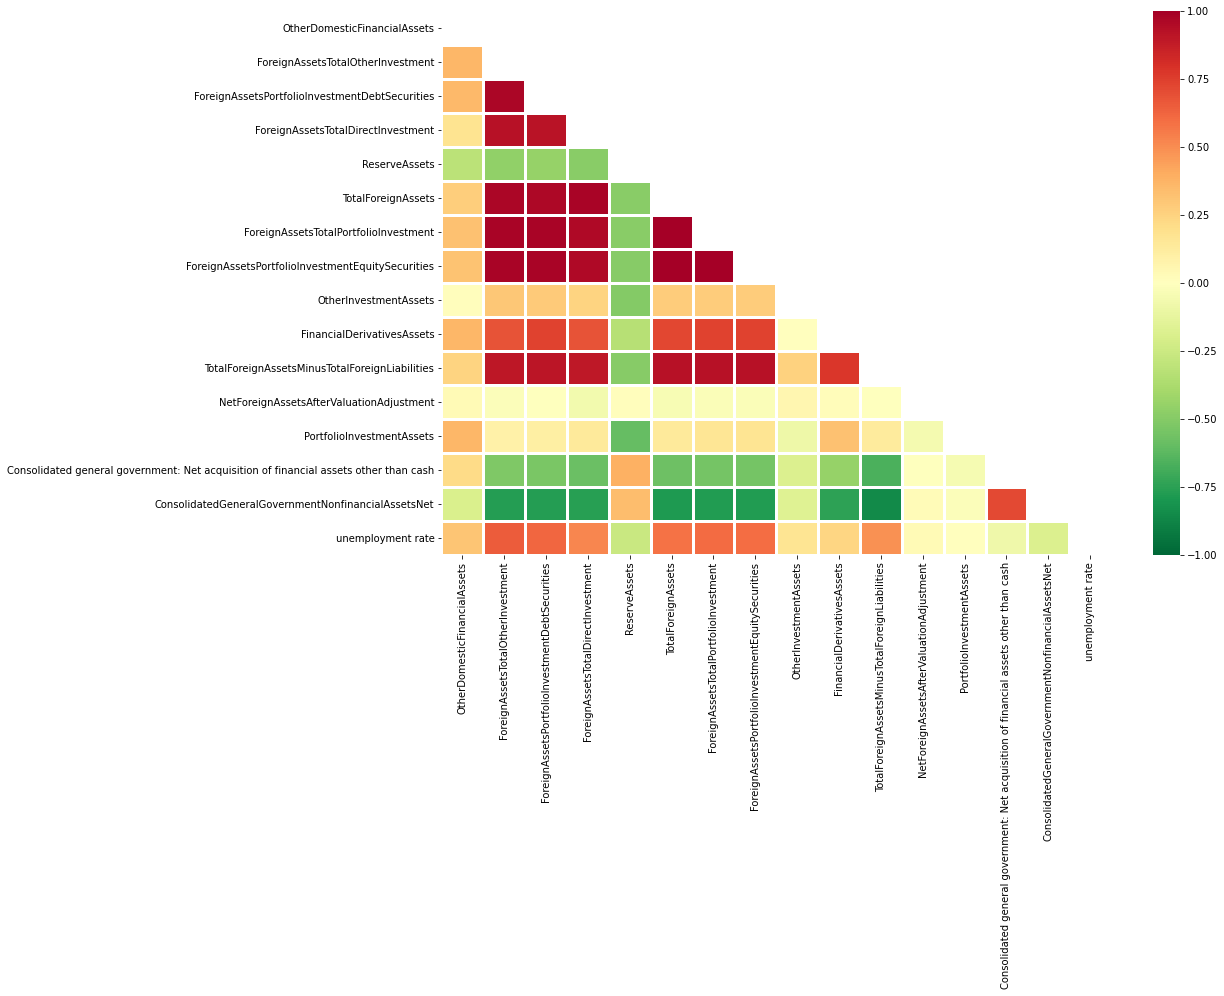

In [14]:
df_assets2 = x_values_ffill[df_out]
df_assets2.rename(columns={'Portfolio investment, assets':'PortfolioInvestmentAssets',
        'Foreign assets: Portfolio investment: Debt securities': 'ForeignAssetsPortfolioInvestmentDebtSecurities',
                        'Consolidated general government: Non-financial assets - Net':'ConsolidatedGeneralGovernmentNonfinancialAssetsNet',
                          'Foreign assets: Total other investment': 'ForeignAssetsTotalOtherInvestment',
                          'Foreign assets: Total direct investment': 'ForeignAssetsTotalDirectInvestment',
                          'Other investment, assets':'OtherInvestmentAssets',
                          'Financial derivatives, assets':'FinancialDerivativesAssets',
                           'Foreign assets: Portfolio investment: Equity securities': 'ForeignAssetsPortfolioInvestmentEquitySecurities',
                          'Other domestic financial assets ':'OtherDomesticFinancialAssets',
                          'Total foreign assets':'TotalForeignAssets',
                          'Total foreign assets minus total foreign liabilities':'TotalForeignAssetsMinusTotalForeignLiabilities',
                          'Net foreign assets after valuation adjustment':'NetForeignAssetsAfterValuationAdjustment',
                          'Foreign assets: Total portfolio investment':'ForeignAssetsTotalPortfolioInvestment',
                          'Reserve assets':'ReserveAssets'}
                  , inplace=True)
del df_assets2["Other reserve assets"]
corr_df = df_assets2.corr(method='pearson')

fig, ax = plt.subplots(figsize=(15,10))


mask=np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(corr_df,cmap='RdYlGn_r',vmax=1.0,vmin=-1.0,mask=mask,linewidths=2.5,ax=ax)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

It appears most of the assets are positively correlated with unemployment rate, however, there is also strong correlation between some assets which may lead to problem of colinearity

#### Here I am separating features from the target variable

In [15]:
X= df_assets2
del X["unemployment rate"]
df2 = y_values_ffill.rename(columns={'unemployment rate':'unemployment_rate'})

y = df2['unemployment_rate']

Earlier on, we saw that some of our fetaures we strongly correlated that could cause issue of multicollinearity, to resolve that, I shall optimize my feature space by removing features with correlation more than 0.8 .

In [16]:
correlated_features = set()
correlation_matrix = X.corr()

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
len(correlated_features)


7

In [17]:
print(correlated_features)

{'ForeignAssetsPortfolioInvestmentEquitySecurities', 'ConsolidatedGeneralGovernmentNonfinancialAssetsNet', 'TotalForeignAssetsMinusTotalForeignLiabilities', 'TotalForeignAssets', 'ForeignAssetsTotalDirectInvestment', 'ForeignAssetsTotalPortfolioInvestment', 'ForeignAssetsPortfolioInvestmentDebtSecurities'}


In [18]:
X.drop(labels=correlated_features, axis=1, inplace=True)
X.shape

(794, 8)

Having obtained the optimized features, below we select them and in our new dataset and plot the correlation matrix.

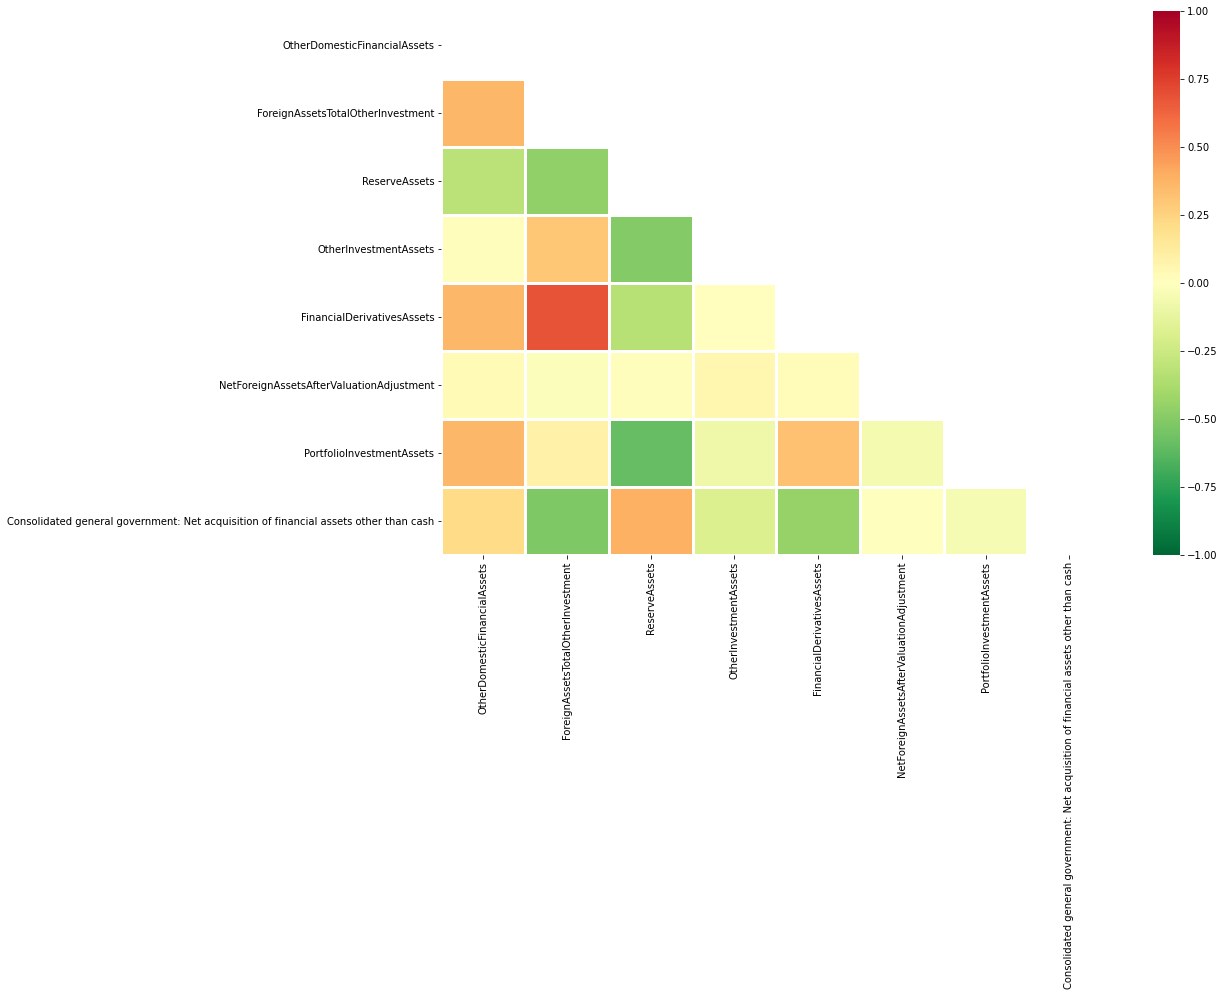

In [19]:
corr_df = X.corr(method='pearson')

fig, ax = plt.subplots(figsize=(15,10))


mask=np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)]=True
sns.heatmap(corr_df,cmap='RdYlGn_r',vmax=1.0,vmin=-1.0,mask=mask,linewidths=2.5,ax=ax)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

## Partitioning the Data into Training(70%) and Testing(30%) sets


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

In [351]:
X_train

,OtherDomesticFinancialAssets,ForeignAssetsTotalOtherInvestment,ReserveAssets,OtherInvestmentAssets,FinancialDerivativesAssets,NetForeignAssetsAfterValuationAdjustment,PortfolioInvestmentAssets,Consolidated general government: Net acquisition of financial assets other than cash
Date,,,,,,,,
1976-08-01,-6629.442857,2.0,-3091.869216,-1558.928058,16261.892086,-77.0,-3364.971223,-8299.903509
1991-01-12,-6629.442857,7.0,88.000000,502.000000,0.000000,1601.0,-159.000000,-352.000000
1996-04-01,-6629.442857,18.0,-752.000000,-3779.000000,0.000000,-4505.0,-1575.000000,-359.000000
1976-01-06,-6629.442857,0.0,-3091.869216,-1558.928058,16261.892086,-243.0,-3364.971223,-8299.903509
2006-10-01,8839.000000,247.0,-7721.000000,3952.000000,0.000000,-17016.0,-4469.000000,-3485.000000
...,...,...,...,...,...,...,...,...
2018-01-03,-18450.000000,528.0,14571.000000,-21611.000000,53339.000000,-17360.0,-15948.000000,-20825.000000
1982-03-01,-6629.442857,3.0,-3091.869216,-1558.928058,16261.892086,-895.0,-3364.971223,-8299.903509
2009-08-01,-14320.000000,251.0,-2288.000000,846.000000,0.000000,22247.0,-9649.000000,-24202.000000


## Modelling phase

### The following function applies step wise linear regression fit to our model

In [327]:
scores_list, optimum_no_features = model_fit(X_train,y_train)
print(optimum_no_features)

0 0.4245171785921674
7


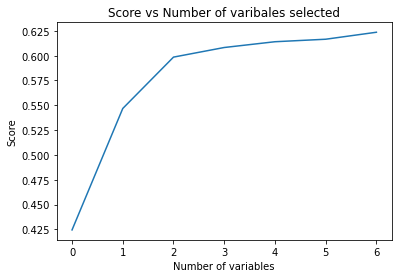

In [328]:
plt_plot(scores_list, 'Score vs Number of varibales selected','Number of variables', 'Score')

### Final model which utilizes optimum number of features, which were returned by the above function

In [329]:
cols_assets = list(X.columns)

selected_features, model, rfe = final_model(optimum_no_features, X_train, y_train,cols_assets)
print(selected_features)

Index(['OtherDomesticFinancialAssets', 'ForeignAssetsTotalOtherInvestment',
       'ReserveAssets', 'OtherInvestmentAssets', 'FinancialDerivativesAssets',
       'NetForeignAssetsAfterValuationAdjustment',
       'Consolidated general government: Net acquisition of financial assets other than cash'],
      dtype='object')


From our stepwise linear regression we have ended with 5 features only 1 redundant one was removed

Now model prediction

In [330]:
y_train_predicted = model.predict(rfe.transform((X_train)))

### Model Analysis


## Post-Stepwise Regression


### Residual analysis


In [331]:
residuals =y_train.astype(float)- (y_train_predicted)

<AxesSubplot:xlabel='unemployment_rate'>

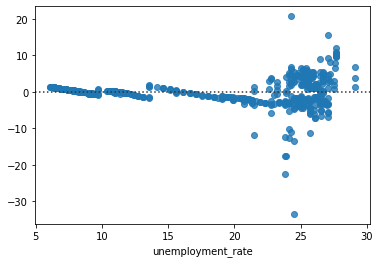

In [332]:
sns.residplot(y_train.astype(float),y_train_predicted)

In [249]:
import statsmodels.formula.api as sm

In [250]:
formula_features = ' + '.join(list(selected_features))
formula = 'unemployment_rate~'+ formula_features
formula

'unemployment_rate~OtherDomesticFinancialAssets + ForeignAssetsTotalOtherInvestment + ReserveAssets + OtherInvestmentAssets + PortfolioInvestmentAssets + Consolidated general government: Net acquisition of financial assets other than cash'

In [251]:
# Add y back to df

X_y_new_train = pd.concat([X_train,pd.DataFrame(y_train)], axis=1)

In [252]:
X_train_y_target = pd.concat([X_train, pd.DataFrame(y_train)], axis=1)
X_train_y_target

,OtherDomesticFinancialAssets,ForeignAssetsTotalOtherInvestment,ReserveAssets,OtherInvestmentAssets,NetForeignAssetsAfterValuationAdjustment,PortfolioInvestmentAssets,Consolidated general government: Net acquisition of financial assets other than cash,unemployment_rate
Date,,,,,,,,
1976-08-01,-4626.5,2.0,-709.0,-399.0,-77.0,-1518.0,-1664.5,6.13100
1991-01-12,-4626.5,7.0,88.0,502.0,1601.0,-159.0,-352.0,13.56330
1996-04-01,-4626.5,18.0,-752.0,-3779.0,-4505.0,-1575.0,-359.0,20.69500
1976-01-06,-4626.5,0.0,-709.0,-399.0,-243.0,-1518.0,-1664.5,6.27541
2006-10-01,8839.0,247.0,-7721.0,3952.0,-17016.0,-4469.0,-3485.0,25.89860
...,...,...,...,...,...,...,...,...
2018-01-03,-18450.0,528.0,14571.0,-21611.0,-17360.0,-15948.0,-20825.0,26.70000
1982-03-01,-4626.5,3.0,-709.0,-399.0,-895.0,-1518.0,-1664.5,7.18285
2009-08-01,-14320.0,251.0,-2288.0,846.0,22247.0,-9649.0,-24202.0,23.20000


In [253]:
results = sm.ols(formula=formula,data = X_train_y_target).fit()
import statsmodels.graphics as smgraphics

axss = smgraphics.regressionplots.plot_fit(results, 2)
_ = smgraphics.regressionplots.plot_fit(results, 1)
_ = smgraphics.regressionplots.plot_fit(results, 3)
_ = smgraphics.regressionplots.plot_fit(results, 4)
_ = smgraphics.regressionplots.plot_fit(results, 5)

SyntaxError: invalid syntax (<unknown>, line 1)

In [ ]:
Y_ols_pred=results.predict(X_train)

In [ ]:
residuals = y_train - Y_ols_pred


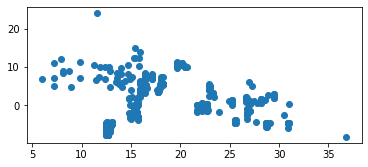

In [254]:
pred_val = results.fittedvalues.copy()
fig, ax = plt.subplots(figsize=(6,2.5))


_ = ax.scatter(pred_val, residuals)

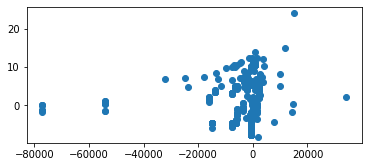

In [255]:
fig, ax1 = plt.subplots(figsize=(6,2.5))
_ = ax1.scatter(X_train.iloc[:,2:3], residuals)

#### Error distribution of residuals

<AxesSubplot:xlabel='unemployment_rate', ylabel='Density'>

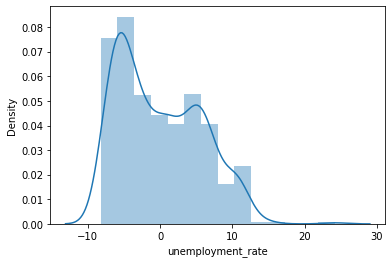

In [256]:
sns.distplot(residuals)

#### QQ plots of sample quantiles vs theoretical ones

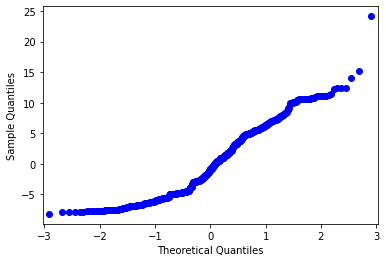

In [257]:
import statsmodels.api as sm
_ = sm.qqplot(residuals)

### Outlier removal


In [258]:
test = results.outlier_test()
outliers = ((x[i],y[i]) for i,t in enumerate(test) if t[2] < 0.5)

In [259]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)


In [260]:
outliers =(i for i,t in enumerate(test.iloc[:,2]) if t < 0.5)

In [261]:
# Index of Outliers
outliers_list = list(outliers)

In [262]:
# Remove outliers
X_train = pd.DataFrame(np.delete(X_train.values, outliers_list,0))
y_train = pd.DataFrame(np.delete(y_train.values, outliers_list,0))
len(X_train)

553

## Final Model

In [263]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)

final_model = rlm(formula, data=X_train_y_target,
                      M=sm.robust.norms.HuberT()).fit()

SyntaxError: invalid syntax (<unknown>, line 1)

In [264]:
X_train

,OtherDomesticFinancialAssets,ForeignAssetsTotalOtherInvestment,ReserveAssets,OtherInvestmentAssets,NetForeignAssetsAfterValuationAdjustment,PortfolioInvestmentAssets,Consolidated general government: Net acquisition of financial assets other than cash
Date,,,,,,,
1976-08-01,-4626.5,2.0,-709.0,-399.0,-77.0,-1518.0,-1664.5
1991-01-12,-4626.5,7.0,88.0,502.0,1601.0,-159.0,-352.0
1996-04-01,-4626.5,18.0,-752.0,-3779.0,-4505.0,-1575.0,-359.0
1976-01-06,-4626.5,0.0,-709.0,-399.0,-243.0,-1518.0,-1664.5
2006-10-01,8839.0,247.0,-7721.0,3952.0,-17016.0,-4469.0,-3485.0
...,...,...,...,...,...,...,...
2018-01-03,-18450.0,528.0,14571.0,-21611.0,-17360.0,-15948.0,-20825.0
1982-03-01,-4626.5,3.0,-709.0,-399.0,-895.0,-1518.0,-1664.5
2009-08-01,-14320.0,251.0,-2288.0,846.0,22247.0,-9649.0,-24202.0


In [265]:
final_model_predicted = final_model.predict(X_test)

AttributeError: 'function' object has no attribute 'predict'

In [266]:
params = np.array(final_model.params)

AttributeError: 'function' object has no attribute 'params'

In [267]:
metrics.r2_score(y_test, final_model_predicted)

NameError: name 'final_model_predicted' is not defined

In [268]:
print_p_values(X_test, y_test, final_model_predicted, params)


NameError: name 'final_model_predicted' is not defined

The test for $H_{0}$ by using the following statistic:
$$
F_{0} = \frac{MS_R}{MS_E}
$$
where $MS_R$ is the regression mean square and $MS_E$ is the error mean square.
<br>
The null hypothesis, $H_{0}$, is rejected if the calculated statistic. $f_{0}, is usch that$
$$
F_{0} > f
$$
I will now test my hypothesist using $F$

In [269]:
def fstat_test(final_model):
    A = np.identity(len(final_model.params))
    A = A[1:,:]
    fvalue = final_model.f_test(A).fvalue
    print("The fvalue is " + str(fvalue[0][0]))

In [270]:
fstat_test(final_model)

AttributeError: 'function' object has no attribute 'params'

In [271]:
degresOfFreedom = len(X_train) - (len(X_train.columns)+1)
scipy.stats.f.ppf(q=1-0.05, dfn=2, dfd=degresOfFreedom)

3.0121989432141616

As shown above, $F_{0} = 110.5337$ and $f = 3.0121$.
<br>
<br>
Since $F_0$ > $f$, $H_{0}$ is rejected and it is concluded that at least one $\beta_{i}$ cofficient is significant. In other words, it is concluded that a regression model exists between the exploratory and response variables

# Unemployement rate in SA: Investigating the relationship between governments profits/losses on investments and unemployment rate in South Africa

## Do investment returns affect the employment rate?

Features about the government's investments were collected from the remaining features with no multi collinearity

In [272]:
def get_inv_features(a, b):
    df_new = list()
    x_col = x_values_ffill.columns.tolist()
    for i in x_col:
        if a in i:
            df_new.append(x_values_ffill[i])
            print(i)
        if b in i:
            df_new.append(x_values_ffill[i])
            print(i)
    return df_new

In [273]:
df_inv = get_inv_features('evalua', 'nvest') 
DF_INV = pd.DataFrame(data = df_inv)

Foreign liabilities: Total portfolio investment 
Foreign liabilities: Portfolio investment: Equity securities
Foreign liabilities: Portfolio investment: Debt securities
Net Investment Position
Foreign liabilities: Total other investment
Foreign assets: Total other investment
Foreign assets: Portfolio investment: Debt securities
The net borrowing requirement of national government equals the net result of the cash-flow deficit/surplus and the cost of revaluation of foreign loans at redemption. 
Foreign assets: Total direct investment
Other investment, liabilities
Foreign assets: Total portfolio investment
Foreign assets: Portfolio investment: Equity securities
Other investment, assets
Cost/profit of revaluation of foreign loans 
Portfolio investment, liabilities
Foreign liabilities: Total direct investment
Direct investment abroad
Portfolio investment, assets
Direct investment in reporting economy


In [274]:
X_INV= DF_INV.transpose()
df2 = df2.rename(columns={'unemployment rate':'unemployment_rate'})
y_inv = df2['unemployment_rate']
X_INV.columns.tolist()

['Foreign liabilities: Total portfolio investment ',
 'Foreign liabilities: Portfolio investment: Equity securities',
 'Foreign liabilities: Portfolio investment: Debt securities',
 'Net Investment Position',
 'Foreign liabilities: Total other investment',
 'Foreign assets: Total other investment',
 'Foreign assets: Portfolio investment: Debt securities',
 'The net borrowing requirement of national government equals the net result of the cash-flow deficit/surplus and the cost of revaluation of foreign loans at redemption. ',
 'Foreign assets: Total direct investment',
 'Other investment, liabilities',
 'Foreign assets: Total portfolio investment',
 'Foreign assets: Portfolio investment: Equity securities',
 'Other investment, assets',
 'Cost/profit of revaluation of foreign loans ',
 'Portfolio investment, liabilities',
 'Foreign liabilities: Total direct investment',
 'Direct investment abroad',
 'Portfolio investment, assets',
 'Direct investment in reporting economy']

In [275]:
def wordopt(text):
    text = text.lower() 
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [276]:
correlated_features = set()
correlation_matrix = X_INV.corr()

for i in range(len(correlation_matrix .columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.8:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)
len(correlated_features)


9

In [277]:
X_INV.drop(labels=correlated_features, axis=1, inplace=True)
X_INV.shape

(794, 10)

In [278]:
for col in X_INV.columns:
    new_w = wordopt(col)
    X_INV.rename(columns= {col: new_w.replace(' ', '')}, inplace = True)
X_train_inv, X_test_inv, y_train_inv, y_test_inv = train_test_split(X_INV,y_inv, test_size = 0.3, random_state = 0)
X_train_inv

,foreignliabilitiestotalportfolioinvestment,netinvestmentposition,thenetborrowingrequirementofnationalgovernmentequalsthenetresultofthecashflowdeficitsurplusandthecostofrevaluationofforeignloansatredemption,otherinvestmentliabilities,otherinvestmentassets,costprofitofrevaluationofforeignloans,portfolioinvestmentliabilities,directinvestmentabroad,portfolioinvestmentassets,directinvestmentinreportingeconomy
Date,,,,,,,,,,
1976-08-01,3.0,-14.0,-73.0,516.0,-399.0,0.0,4094.0,-1278.0,-1518.0,1919.0
1991-01-12,28.0,-37.0,1686.0,-72.0,502.0,0.0,887.0,-641.0,-159.0,-508.0
1996-04-01,112.0,-132.0,-3464.0,10757.0,-3779.0,0.0,-516.0,-1278.0,-1575.0,1296.0
1976-01-06,0.0,0.0,-26.0,516.0,-399.0,0.0,4094.0,-1278.0,-1518.0,1919.0
2006-10-01,716.0,-459.0,-4445.0,2371.0,3952.0,-540.0,31519.0,5980.0,-4469.0,-10447.0
...,...,...,...,...,...,...,...,...,...,...
2018-01-03,3491.0,343.0,-90387.0,1060.0,-21611.0,0.0,89416.0,-20792.0,-15948.0,9262.0
1982-03-01,6.0,-26.0,-253.0,516.0,-399.0,-69.0,4094.0,-1278.0,-1518.0,1919.0
2009-08-01,934.0,-423.0,-7514.0,689.0,846.0,-16.0,41241.0,-5374.0,-9649.0,7933.0


In [279]:
def invest_model_fit(X_fit,y_fit):    
    feature_list=np.arange(1, len(X_train_inv.columns))            
    high_score=0
    optimum_no_features=0           
    score_list =[]
    for n in range(len(feature_list)):
        model = LinearRegression()
        rfe = RFE(model,feature_list[n])
        X_train_rfe = rfe.fit_transform(X_train_inv,y_train_inv)
        model.fit(X_train_rfe,y_train_inv)

        score = r2_score(y_fit, model.predict(X_train_rfe))
        score_list.append(score)

        if(score>high_score):
            high_score = score  
            optimum_no_features = feature_list[n]
    return score_list, optimum_no_features 


In [280]:
scores_list_inv, optimum_no_features_inv = invest_model_fit(X_train_inv,y_train_inv)
print("Number of features selected:",optimum_no_features_inv)

Number of features selected: 9


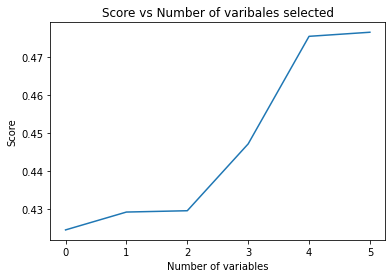

In [281]:
plt_plot(scores_list, 'Score vs Number of varibales selected','Number of variables', 'Score')

The r squared scores seem to be increasing for the selected investment features. The scores remain less that 0.4 probably because of the small number of features used

In [282]:
def final_inv_model(n, X_final_inv, y_final_inv):
    cols = list(X_INV.columns)
    model = LinearRegression()
    #Initializing RFE model
    rfe = RFE(model, n)             
    #Transforming data using RFE
    x_fitted = rfe.fit_transform(X_final_inv,y_final_inv)  
    #Fitting the data to model
    model.fit(x_fitted,y_final_inv)              
    temp = pd.Series(rfe.support_,index = cols)
    selected_features = temp[temp==True].index
    return selected_features, model, rfe

In [283]:
print(optimum_no_features_inv)
selected_inv_features, inv_model, inv_rfe = final_inv_model(optimum_no_features_inv, X_train_inv, y_train_inv)
selected_inv_features.tolist()

9


['foreignliabilitiestotalportfolioinvestment',
 'netinvestmentposition',
 'otherinvestmentliabilities',
 'otherinvestmentassets',
 'costprofitofrevaluationofforeignloans',
 'portfolioinvestmentliabilities',
 'directinvestmentabroad',
 'portfolioinvestmentassets',
 'directinvestmentinreportingeconomy']

In [284]:
y_train_inv_predicted = inv_model.predict(inv_rfe.transform((X_train_inv)))

## Residual Analysis

<AxesSubplot:xlabel='unemployment_rate'>

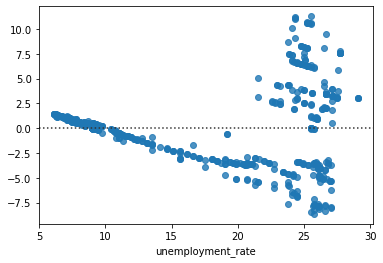

In [285]:
inv_residuals =y_train_inv.astype(float)- (y_train_inv_predicted)
sns.residplot(y_train_inv.astype(float),y_train_inv_predicted)

The residual points are not evenly dustributed vertically. The predictions get worse as the unemployment rate increases. The residuals show heteroscedasticity pattern which happens when regression assumes that the residuals come data with constant variance. This resuslts in low confidence in the model.

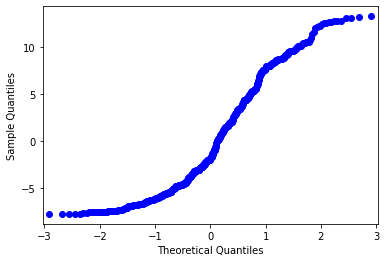

In [286]:
import statsmodels.api as sm
_ = sm.qqplot(inv_residuals)

<AxesSubplot:xlabel='unemployment_rate', ylabel='Density'>

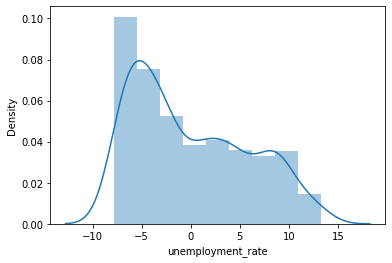

In [287]:
sns.distplot(inv_residuals)

The residuals are not normally distributed

In [203]:
formula_inv_features = ' + '.join(list(selected_inv_features))
formula_inv = 'unemployment_rate~'+ formula_inv_features

In [204]:
X_y_new_inv_train = pd.concat([X_train_inv,pd.DataFrame(y_train_inv)], axis=1)

In [205]:
X_train_y_target_INV = pd.concat([X_train_inv, pd.DataFrame(y_train_inv)], axis=1)

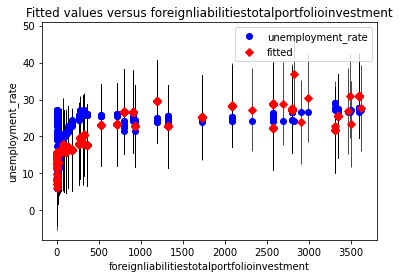

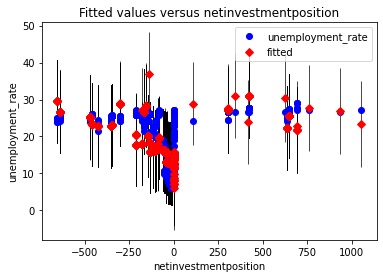

In [206]:
import statsmodels.formula.api as sm
results = sm.ols(formula=formula_inv,data = X_train_y_target_INV).fit()
import statsmodels.graphics as smgraphics

axss = smgraphics.regressionplots.plot_fit(results, 1)
_ = smgraphics.regressionplots.plot_fit(results, 2)

# Final Investment Model

In [207]:
import statsmodels.api as sm
final_inv_model = rlm(formula_inv, data=X_train_y_target_INV,
                      M=sm.robust.norms.HuberT()).fit()

In [208]:
final_inv_model_predicted = final_inv_model.predict(X_test_inv)
inv_params = np.array(final_inv_model.params)
print(inv_params.shape)
print(X_test_inv.shape)
metrics.r2_score(y_test_inv, final_inv_model_predicted)

(10,)
(239, 10)


0.4056319938200357

In [209]:
def print_p_values_inv(x_test, y_test, predicted, params):
    """
    Calculates the p value, based on https://stackoverflow.com/a/42677750/9260653
    """
    newX = np.append(np.ones((len(x_test),1)), x_test, axis=1)
    MSE = (sum((y_test.values-predicted)**2))/(len(newX)-len(newX[0]))

    var_b = MSE*(np.linalg.pinv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)[:-1]
    print(params.shape)
    ts_b = params/ sd_b
    
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,4)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["P-Values"] = [params,sd_b,ts_b,p_values]
    print(myDF3.iloc[1])

In [210]:
# inv_params.shape
print_p_values_inv(X_test_inv, y_test_inv, final_inv_model_predicted, inv_params)


(10,)
Coefficients        0.0088
Standard Errors     0.0010
t values           12.6690
P-Values            0.0000
Name: 1, dtype: float64


In [211]:
def fstat_test(final_model):
    A = np.identity(len(final_model.params))
    A = A[1:,:]
    fvalue = final_model.f_test(A).fvalue
    print("The f value is " + str(fvalue[0][0]))

In [212]:
fstat_test(final_inv_model)
degresOfFreedom = len(X_train_inv) - (len(X_train_inv.columns)+1)
scipy.stats.f.ppf(q=1-0.05, dfn=2, dfd=degresOfFreedom)

The f value is 101.95850718620125


3.012290086049356

With a p-value 0f less than 0.01 and f value = 51.55 greater than f = 3.012 showing high significance, we can reject the hypothesis that investment has an effect on unemployment rate.

#  Unemployement rate in SA: Exploring the multi-variables of cash flow in South Africa that affects the rate of unemployement

## 3. How does the government cash flow affect unemployment rate?

### Function to select varables about the subsidiary topic
This helper function helps with selecting featues names for the topic I am focusing on

In [25]:
  """
    helper function helps with selecting featues names that are aboout the speific topic that needs to be researched


    Parameters:
    -----------
    s: string, column name
    returns a list of variables names that are about cash flow 
    
    """

def get_features(a):
    df_new = list()
    x_col = x_values_ffill.columns.tolist()
    for i in x_col:
        if a in i:
            df_new.append(x_values_ffill[i])
            print(i)
    return df_new

Below I am creating a new dataset which only contains appropriate varibales that suit the subsidiary topic

In [27]:
df_cash = get_features('cash') # get appropriate feature names
DF = pd.DataFrame(data = df_cash) # create a new dataset which only contains appropriate varibales that need to be reseache

Total cash-flow revenue
Cash received from the issuance of other debt instruments less cash payments made to redeem other debt instruments, including non-marketable bills and bonds, and debt of the former TBVC-countries, self-governing territories and the Republic of Namibia that were assumed by the national government. 
Consolidated general government: Net change in the stock of cash_x
Cash received from the issuance of domestic government bonds less cash payments made to redeem domestic government bonds.
The net borrowing requirement of national government equals the net result of the cash-flow deficit/surplus and the cost of revaluation of foreign loans at redemption. 
Cash received from the issuance of foreign bonds and loans less cash payments made to redeem foreign bonds and loans.
Cash received from the issuance of Treasury bills less cash payments made to redeem Treasury bills.
The difference between cash-flow revenue and cash-flow expenditure._x
The difference between cash-flo

In [28]:
X_cash= DF.transpose() # transpose the data to be in a correct form
X_cash

,Total cash-flow revenue,"Cash received from the issuance of other debt instruments less cash payments made to redeem other debt instruments, including non-marketable bills and bonds, and debt of the former TBVC-countries, self-governing territories and the Republic of Namibia that were assumed by the national government.",Consolidated general government: Net change in the stock of cash_x,Cash received from the issuance of domestic government bonds less cash payments made to redeem domestic government bonds.,The net borrowing requirement of national government equals the net result of the cash-flow deficit/surplus and the cost of revaluation of foreign loans at redemption.,Cash received from the issuance of foreign bonds and loans less cash payments made to redeem foreign bonds and loans.,Cash received from the issuance of Treasury bills less cash payments made to redeem Treasury bills.,The difference between cash-flow revenue and cash-flow expenditure._x,The difference between cash-flow revenue and cash-flow expenditure._y,Consolidated general government: Net change in the stock of cash_y,Consolidated general government: Net cash-flow from financing activities,Consolidated general government: Net acquisition of financial assets other than cash,Net cash-flow from operating activities
Date,,,,,,,,,,,,,
1970-03-01,4.0,4.0,3635.245614,4574.275058,-261.0,14.0,44.0,-17795.915254,-261.0,3635.245614,18254.578947,-8299.903509,314.333333
1970-04-01,1.0,-18.0,3635.245614,4574.275058,-23.0,0.0,3.0,-17795.915254,-23.0,3635.245614,18254.578947,-8299.903509,314.333333
1970-05-01,2.0,3.0,3635.245614,4574.275058,-32.0,-1.0,-20.0,-17795.915254,-32.0,3635.245614,18254.578947,-8299.903509,314.333333
1970-06-01,1.0,-2.0,3635.245614,4574.275058,-6.0,24.0,31.0,-17795.915254,-6.0,3635.245614,18254.578947,-8299.903509,314.333333
1970-07-01,3.0,3.0,3635.245614,4574.275058,39.0,0.0,-26.0,-17795.915254,39.0,3635.245614,18254.578947,-8299.903509,314.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-09-01,0.0,-1991.0,32703.000000,31941.000000,15851.0,76052.0,-17324.0,-4965.000000,-4965.0,32703.000000,114791.000000,-33215.000000,-55201.000000
2019-10-01,0.0,-2057.0,32703.000000,28767.000000,-36828.0,-392.0,7778.0,-42739.000000,-42739.0,32703.000000,114791.000000,-33215.000000,-55201.000000
2019-11-01,0.0,-1764.0,32703.000000,29604.000000,-24595.0,-2.0,6127.0,-34039.000000,-34039.0,32703.000000,114791.000000,-33215.000000,-55201.000000


## Emperical Analysis

In this section I will be analysing the features that are going to be used to model the subsdiary question

In [32]:
correlation = X_cash.corr()

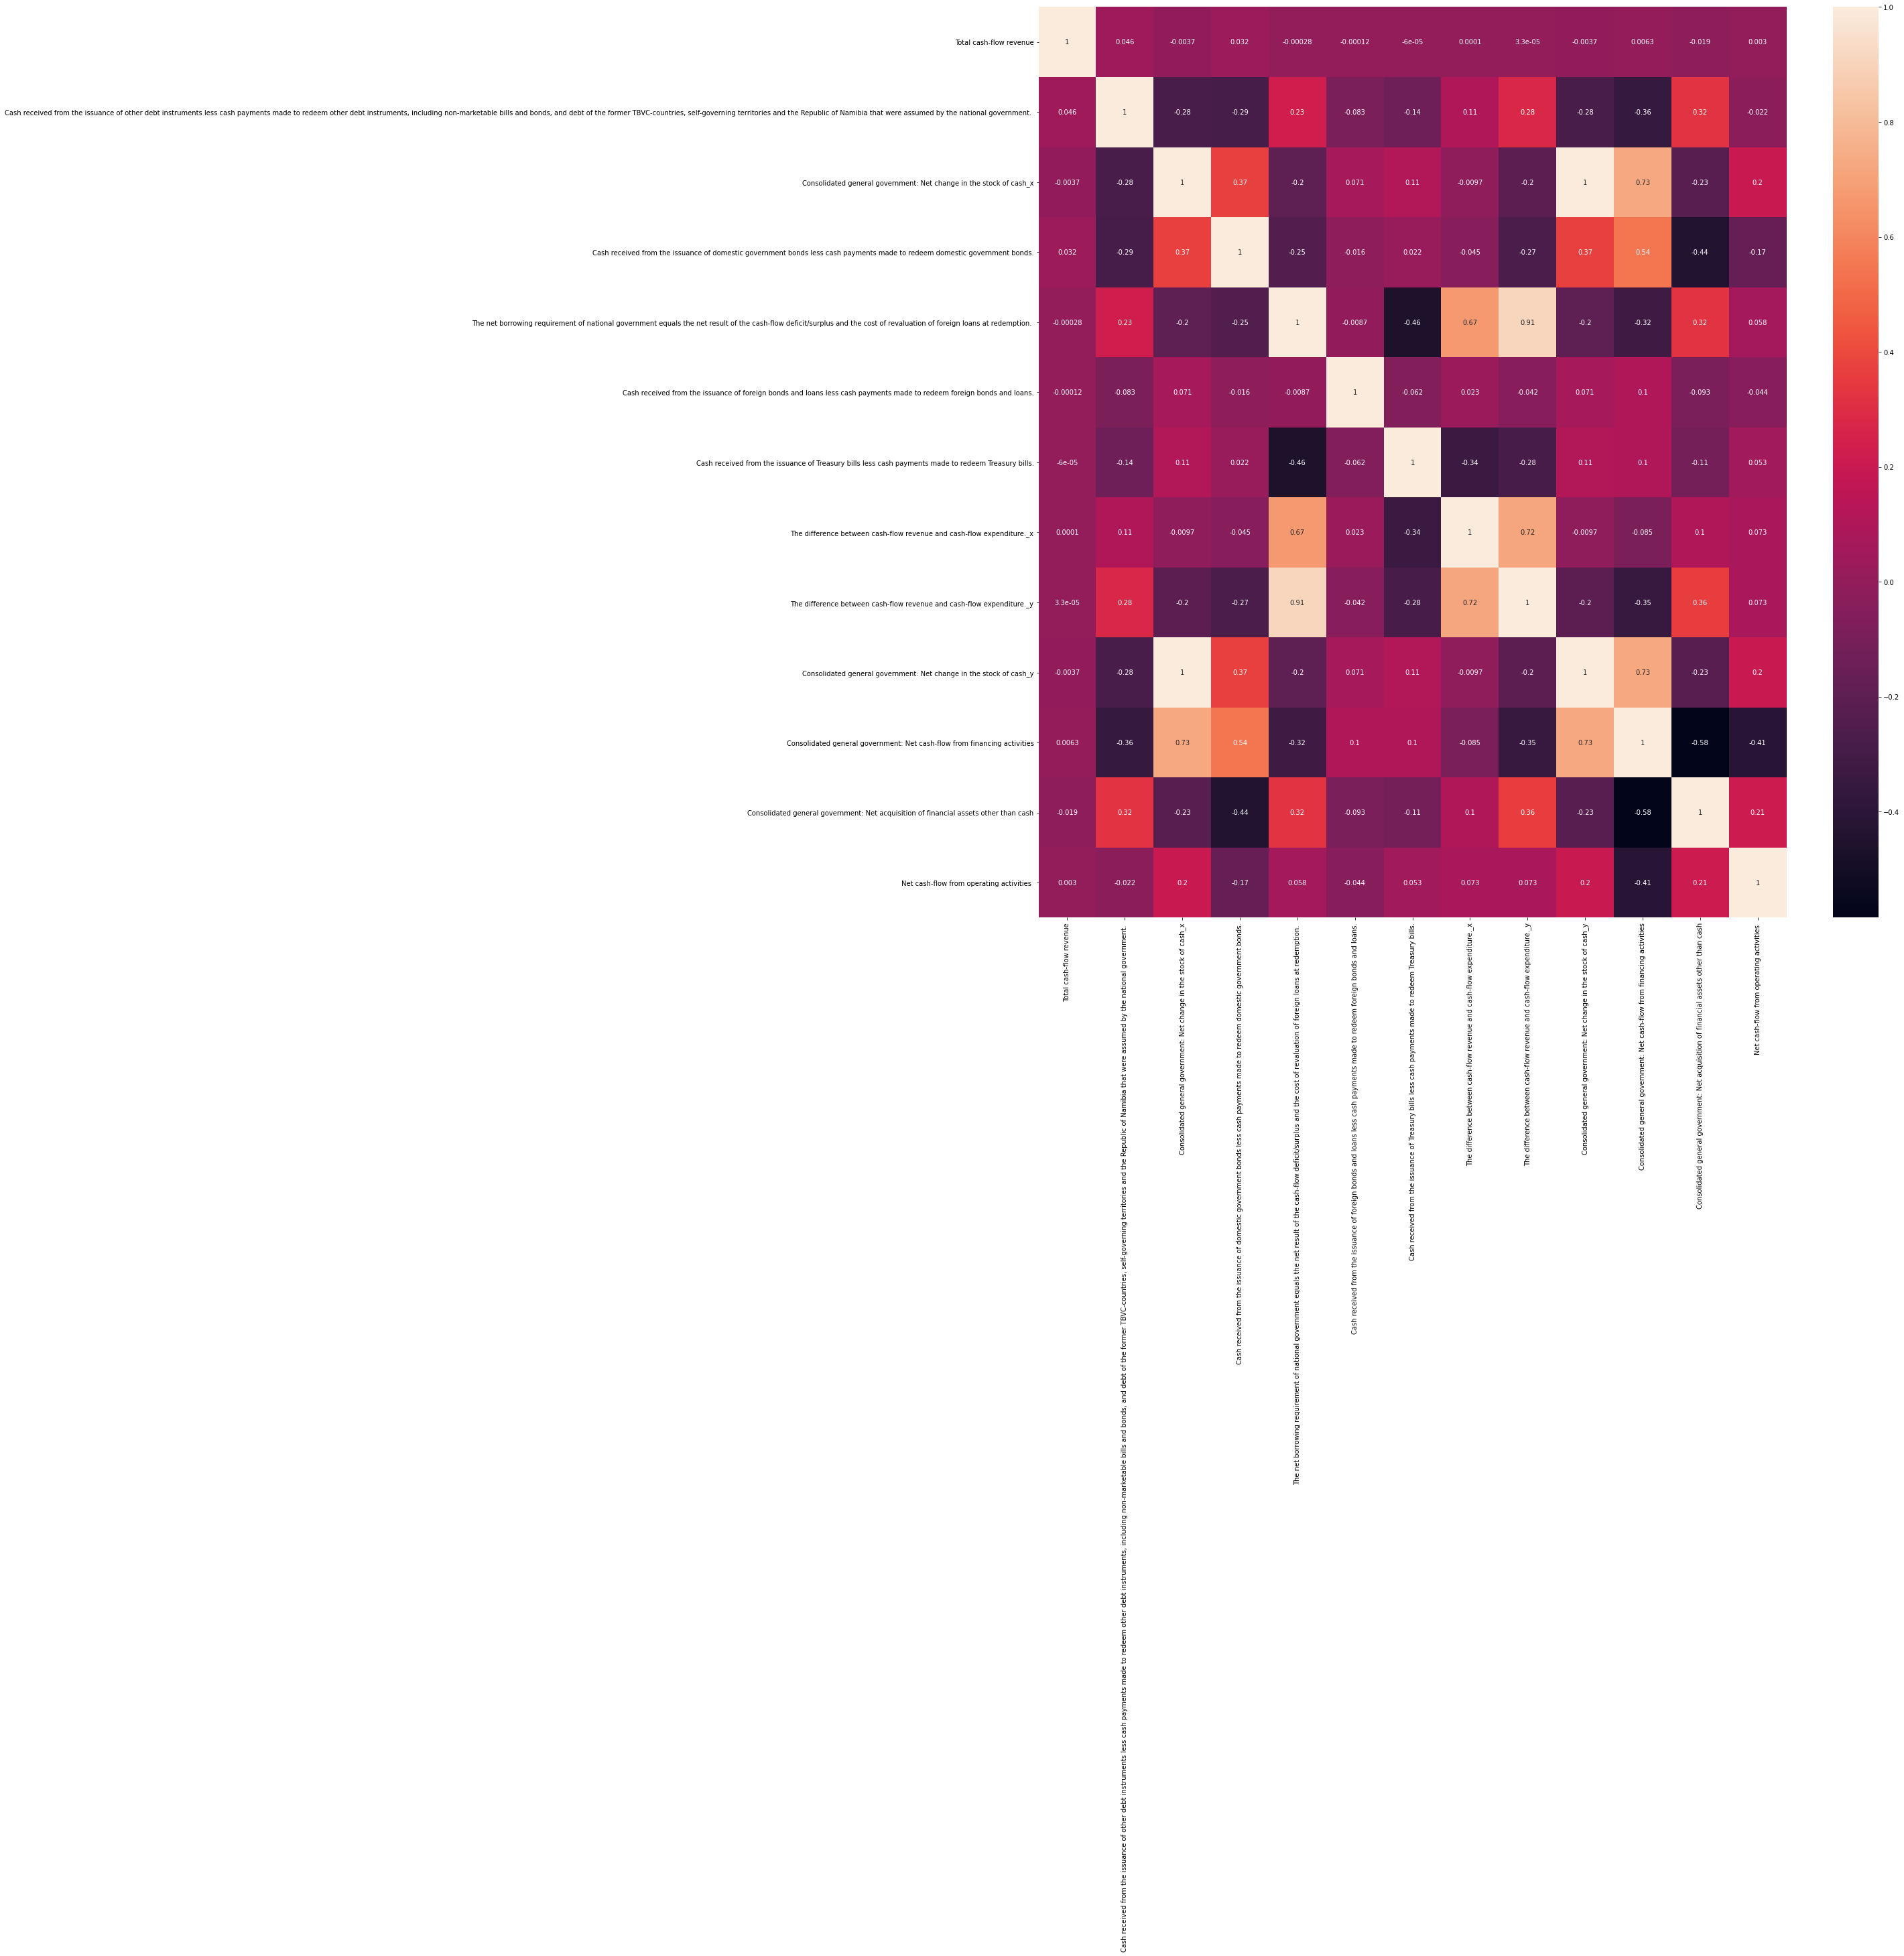

In [44]:
ax = plt.subplots(figsize=(25,25))
ax = sns.heatmap(correlation, xticklabels = correlation.columns, yticklabels = correlation.columns, annot = True)

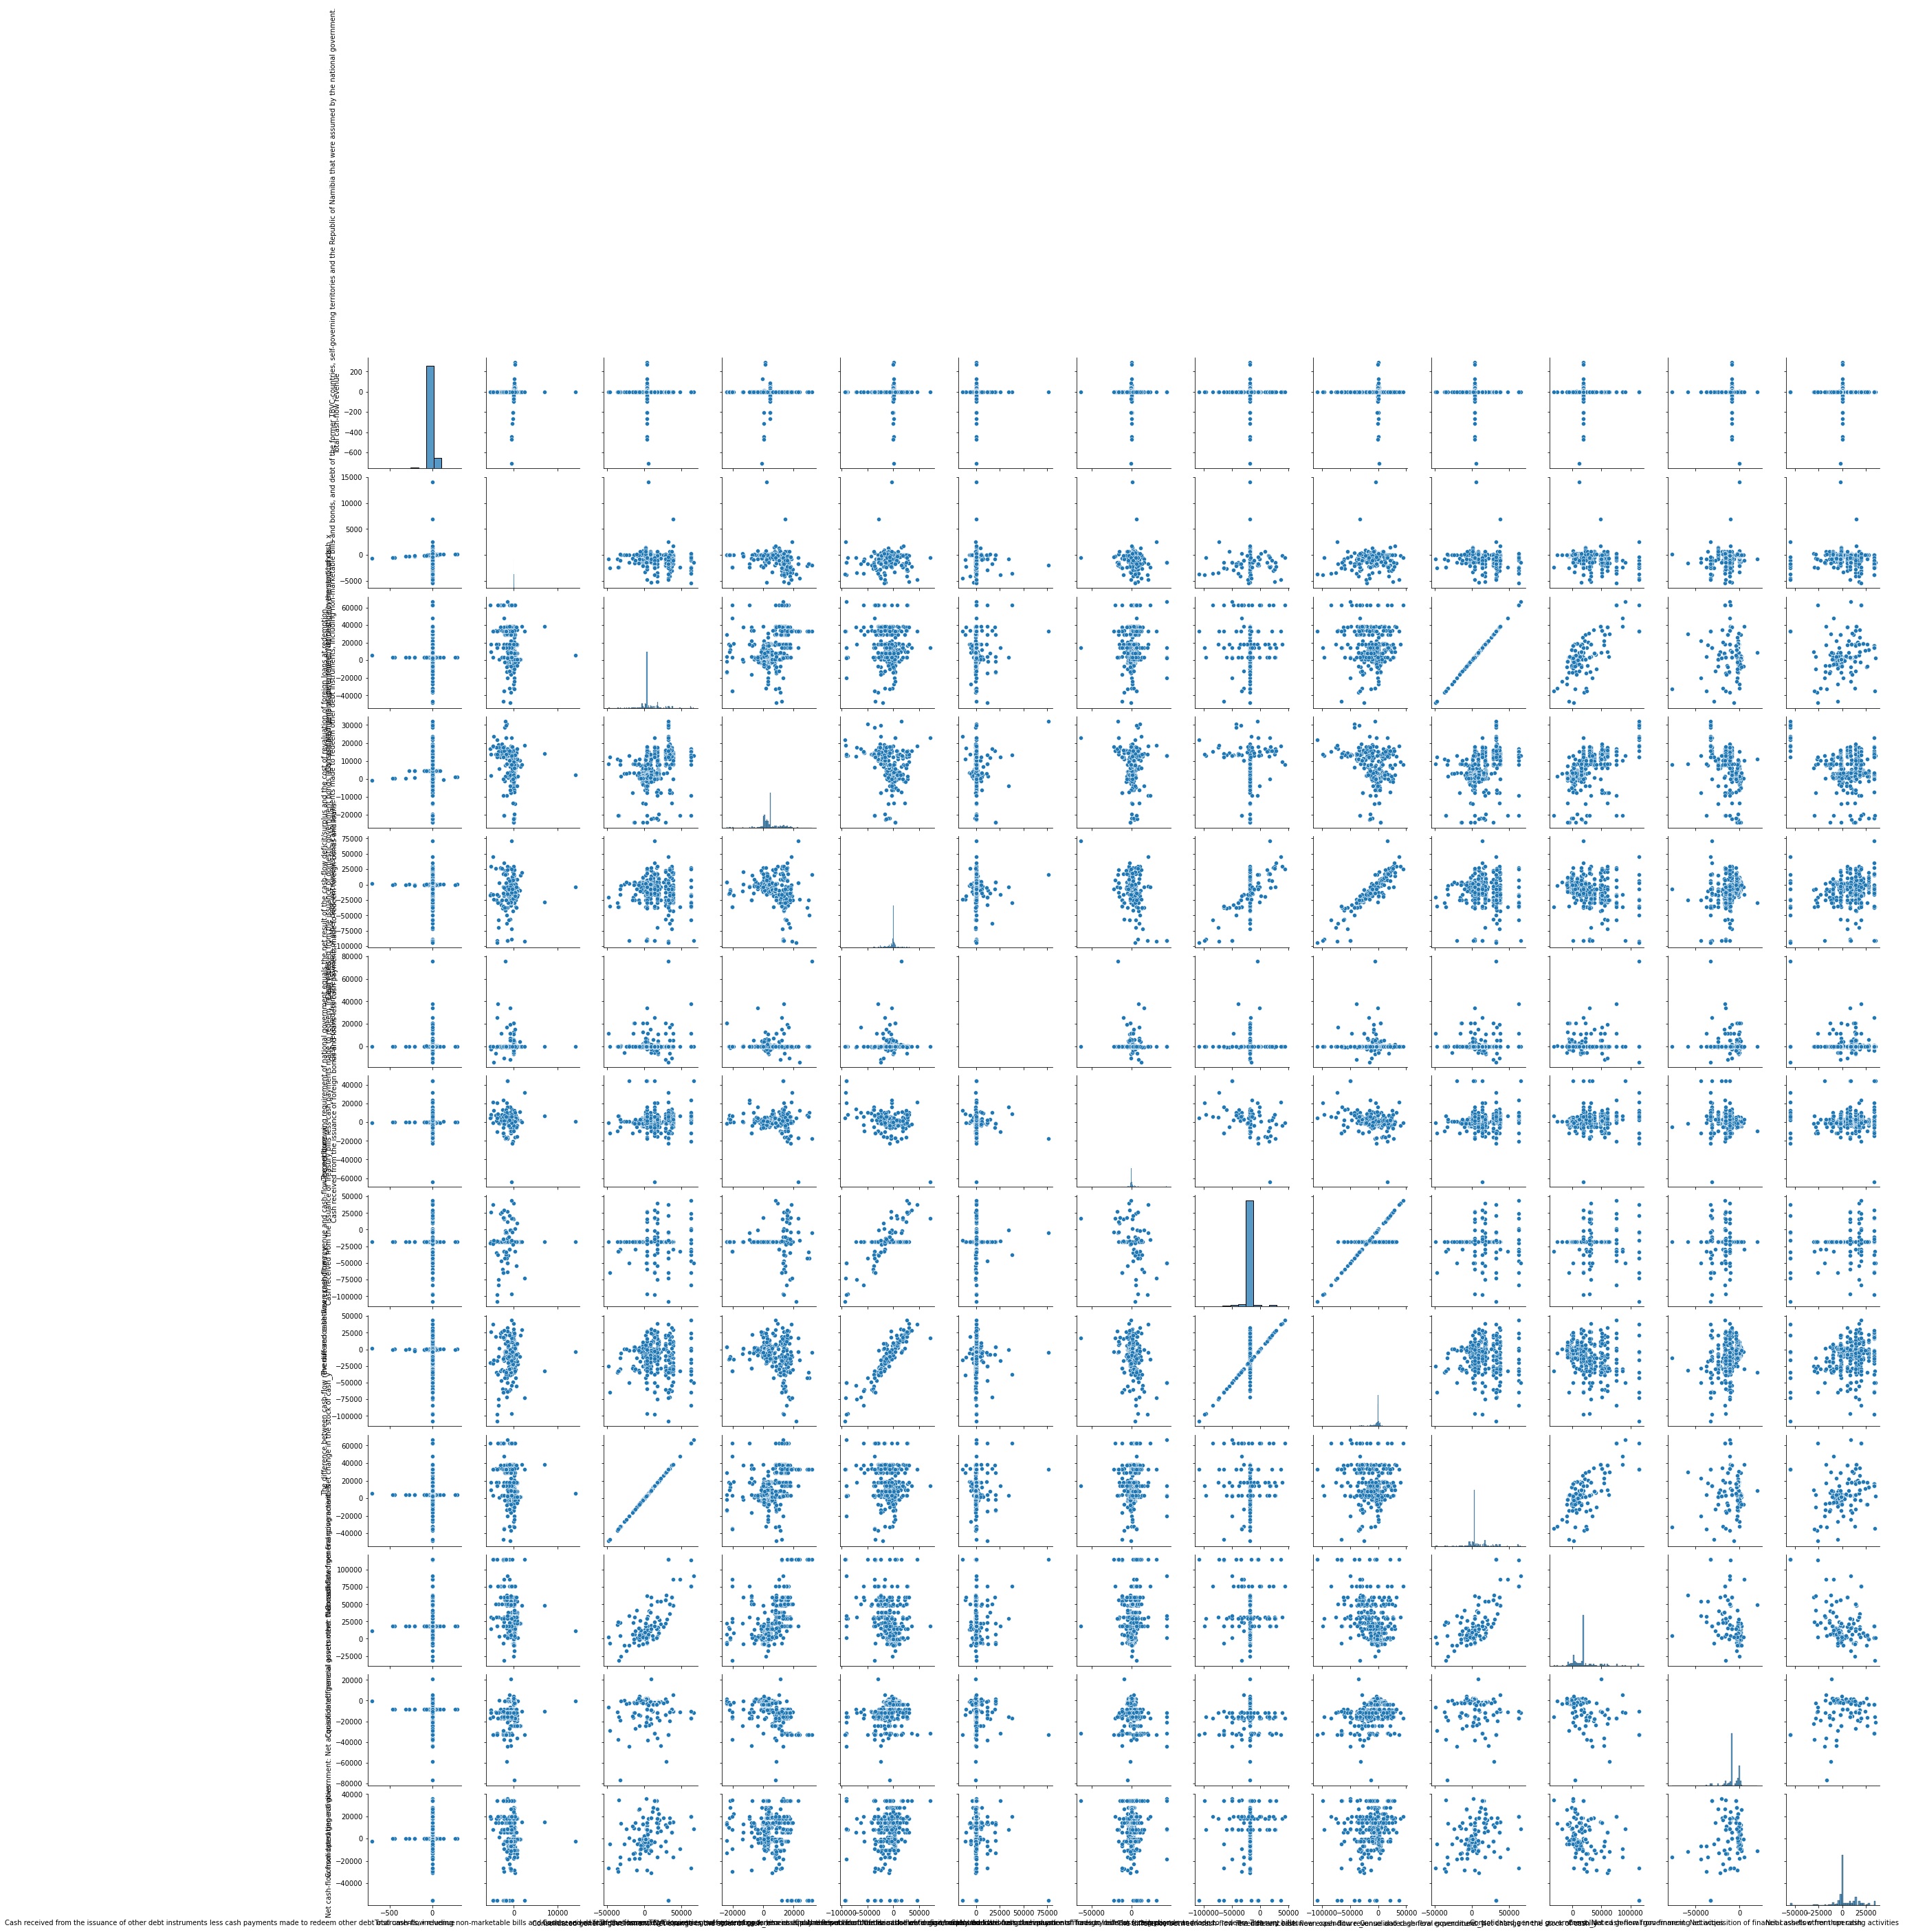

In [45]:
sns.pairplot(X_cash)

## Dealing with Collinearity
Below I omitthe offending variables using the dimensionality reduction. This done to avoid collinearity from reducing the precision of the estimated coefficients, which weakens the statistical power of your regression model

In [ ]:
threshhold = 0.5 # the threshhold that is used to select features
correlated_features_cash = set() # a set which stores features that are available after dealing with collinearity
correlation_matrix_cash = X_cash.corr() # getting th correlation of the features

for i in range(len(correlation_matrix_cash.columns)): # loop through the features
    for j in range(i):
        if abs(correlation_matrix_cash.iloc[i, j]) > threshhold: # detecting all features that have correlation less greater than 0.5
            colname = correlation_matrix_cash.columns[i] # selecting features with less correlation
            correlated_features_cash.add(colname) # creating new dataset with no high correlated variables
len(correlated_features_cash) # the remaining features


## Removing spaces from the varibales (Data wrangling maybe???)
This is done to make it easier work with columns name

In [ ]:
for col in X_cash.columns: #selecting the features 
    new_w = wordopt(col) #removing all unnecesary characters
    X_cash.rename(columns= {col: new_w.replace(' ', '')}, inplace = True) # removing spaces from columns names

Y_cash = df2['unemployment_rate'] # removing space from target variblles


### Data splitting

The predefined ratio used for data splitting is 70/30 reason being that I want to improve the accuracy of the evaluation of the model.


In [369]:
X_train_cash, X_test_cash, y_train_cash, y_test_cash = train_test_split(X_cash,Y_cash, test_size = 0.3, random_state = 0) # splitting datset into 70/30 ratio using sklearn

NameError: name 'X_cash' is not defined

## Modeling - Stepwise regression

In this section I employ procedures to search through the model space to select a model. In other words,it is an iterative construction procedure of a regression model that involves the selection of independent variables to be used in a final model

In [ ]:
scores_list_cash, optimum_no_features_cash = model_fit(X_train_cash,y_train_cash)

In [215]:
plt_plot(scores_list_cash, 'Score vs Number of varibales selected','Number of variables', 'Score')

NameError: name 'scores_list_cash' is not defined

## Forward selection feature selection
This is how the following methods behaves, at first it begins with no variables in the model, tests each variable as it is added to the model, then keeps those that are deemed most statistically significant—repeating the process until the results are optimal

In [216]:
# fit final model using optimum number of features from prev function
"""final_model_cash :Linear model designed by forward selection.

    Parameters:
    -----------
    X_train: pandas DataFrame with all the explaratory variables

    y_train: pandas Series, series of response variable

    Returns:
    --------
    selected_features_cash: number of selectedinput features
    
    model: linear regression model
    
    rfe: gives the ranking of all the variables, 1 being most important.
    """

def final_model_cash(optimum_no_features, X_train, y_train):
    cols = list(X_cash.columns)
    model = LinearRegression()
    #Initializing RFE model
    rfe = RFE(model, optimum_no_features)  # RFE method takes the model to be used and the number of required features as input          
    x_fitted = rfe.fit_transform(X_train,y_train)   #Transforming data using RFE
    #Fitting the data to model
    model.fit(x_fitted,y_train)              
    temp = pd.Series(rfe.support_,index = cols)
    selected_features = temp[temp==True].index
    return selected_features, model, rfe

Fitting linear model to select features for the model using forward selection

In [217]:
selected_features_cash, model_cash, rfe_cash = final_model_cash(optimum_no_features_cash, X_train_cash, y_train_cash)

NameError: name 'optimum_no_features_cash' is not defined

using training features to predict the model

In [218]:
y_train_predicted_cash = model_cash.predict(rfe_cash.transform((X_train_cash))) #using training features to predict the model

NameError: name 'model_cash' is not defined

## Model Fit Analaysis

# Post-Stepwise Regression

## Residual Analysis
Here I use the resudual analysis for validating the regression model. If the dots are randomly dispersed around the horizontal axis then a linear regression model is appropriate for the data.

In [219]:
residuals = y_train_cash-y_train_predicted_cash # calculating the residual of the  target variable foir training

NameError: name 'y_train_cash' is not defined

In [220]:
sns.residplot(y_train_cash,y_train_predicted_cash) #plotting the residual plot

NameError: name 'y_train_cash' is not defined

### applying normal probability plot to assess how the data (error) depart from normality visually:


creating formula of the selected features for linear regression model

In [221]:
# creating formula of the selected features for linear regression model
formula_features_cash = ' + '.join(list(selected_features_cash)) # selected features formula
formula_cash = 'unemployment_rate~'+ formula_features_cash # target feature formula

NameError: name 'selected_features_cash' is not defined

?? not sure

In [222]:
# Add y back to df
X_y_new_train_cash = pd.concat([X_train_cash,pd.DataFrame(y_train_cash)], axis=1)


NameError: name 'X_train_cash' is not defined

In [ ]:
X_train_y_target_cash = pd.concat([X_train_cash, pd.DataFrame(y_train_cash)], axis=1)
# X_train_y_target

Here I plot the model for the features selected above

In [ ]:
import statsmodels.graphics as smgraphics
import statsmodels.formula.api as sm

results_cash = sm.ols(formula=formula_cash,data = X_train_y_target_cash).fit() # fitting linear regression
axss_cash = smgraphics.regressionplots.plot_fit(results_cash,3) # plotting regression plot for feature 3


The above plot regression plot of feature 3, **consolodated general government change in the stock cach**

In [ ]:
Y_ols_pred_cash=results_cash.predict(X_train_cash)

In [ ]:
residuals_cash = y_train_cash - Y_ols_pred_cash


In [ ]:
fig, ax1 = plt.subplots(figsize=(6,2.5))
_ = ax1.scatter(X_train_cash.iloc[:,5:6], residuals_cash)

In [ ]:
sns.distplot(residuals)

In [ ]:
import statsmodels.api as sm
_ = sm.qqplot(residuals_cash)

### Outlier Detection and removal
Here outliers are detected and deleted and used the remaining observations for fitting the model.

In [ ]:
test_cash = results.outlier_test()
outliers_cash = ((x[i],y[i]) for i,t in enumerate(test) if t[2] < 0.5)

In [ ]:
X_train_cash, X_test_cash, y_train_cash, y_test_cash = train_test_split(X_cash,Y_cash, test_size = 0.3, random_state = 0)


In [ ]:
outliers_cash =(i for i,t in enumerate(test.iloc[:,2]) if t < 0.5)

In [ ]:
# Index of Outliers
outliers_list_cash = list(outliers)


In [ ]:
# Remove outliers
X_train_cash = pd.DataFrame(np.delete(X_train_cash.values, outliers_list_cash,0))
y_train_cash = pd.DataFrame(np.delete(y_train_cash.values, outliers_list_cash,0))


## Final Model


In [ ]:
X_train_cash, X_test_cash, y_train_cash, y_test_cash = train_test_split(X_cash,Y_cash, test_size = 0.3, random_state = 0)

final_model_cash = rlm(formula_cash, data=X_train_y_target_cash,
                      M=sm.robust.norms.HuberT()).fit()

In [ ]:
final_model_predicted_cash = final_model_cash.predict(X_test_cash)

In [ ]:
params_cash = np.array(final_model_cash.params)

In [ ]:
metrics.r2_score(y_test, final_model_predicted)

In [ ]:
print_p_values(X_test_cash, y_test_cash, final_model_predicted_cash, params_cash)


he test for $H_{0}$ byusing the following statistic:
$$
F_{0} = \frac{MS_R}{MS_E}
$$
where $MS_R$ is the regression mean square and $MS_E$ is the error mean square.
<br>
The null hypothesis, $H_{0}$, is rejected if the calculated statistic. $f_{0}, is usch that$
$$
F_{0} > f
$$
I will now test my hypothesist using $F$

In [ ]:
def fstat_test(final_model):
    A = np.identity(len(final_model.params))
    A = A[1:,:]
    fvalue = final_model.f_test(A).fvalue
    print("The fvalue is " + str(fvalue[0][0]))

In [ ]:
fstat_test(final_model)

In [ ]:
degresOfFreedom = len(X_train) - (len(X_train.columns)+1)
scipy.stats.f.ppf(q=1-0.05, dfn=2, dfd=degresOfFreedom)

As shown above, $F_{0} = 110.5337$ and $f = 3.004779$.
<br>
<br>
Since $F_0$ > $f$, $H_{0}$ is rejected and it is concluded that at least one $\beta_{i}$ cofficient is significant. In other words, it is concluded that a regression model exists between the exploratory and response variables

# Unemployement rate in SA: Exploring the relationship between multiple variables that may influence the unemployment rate of South Africa

## 4. How does the government debt affect unemployment rate?

In [ ]:
predictors = x_values_ffill
DF_Y = y_values_ffill

In [ ]:
def get_features(s):
    df_new = pd.DataFrame()

    for i in predictors:        
        if s in i:
            df_new[i] = predictors[i]

    return df_new

In [ ]:
df_new_1 = get_features('debt')
df_new_2 = get_features('outstanding')
df = pd.concat([df_new_1 , df_new_2 , DF_Y], axis=1)

# Exploratory Plots

In [ ]:
sns.heatmap(df.corr())

# Colinearity

In [ ]:
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

In [ ]:
# removing all the corrated values with a correlation value over 0.7
DF_X = df.copy()
correlation(DF_X,0.7)

In [ ]:
values = list(DF_X.columns)
keys = list('ABCDEFGH')

zip1 = zip(keys, values)



dictionary = dict(zip1)


print(dictionary)

In [ ]:
DF_X.columns = keys
DF_Y.columns = ['unemployment_rate']

# Modelling
## Stepwise regression

In [ ]:
X_train_debt, X_test_debt, y_train_debt, y_test_debt = train_test_split(DF_X,DF_Y, test_size = 0.3, random_state = 0)

In [ ]:


def final_model_debt(optimum_no_features, X_train, y_train):
    cols = list(DF_X.columns)
    model = LinearRegression()
    #Initializing RFE model
    rfe = RFE(model, optimum_no_features)             
    #Transforming data using RFE
    x_fitted = rfe.fit_transform(X_train,y_train)  
    #Fitting the data to model
    model.fit(x_fitted,y_train)              
    temp = pd.Series(rfe.support_,index = cols)
    selected_features = temp[temp==True].index
    return selected_features, model, rfe

In [ ]:
# Train model using X_train, y_train
X_train_debt
scores_list_debt, optimum_no_features_debt = model_fit(X_train_debt,y_train_debt)

In [ ]:
plt_plot(scores_list_debt, 'Score vs Number of varibales selected','Number of variables', 'Score')

In [ ]:
selected_features_debt, model_debt, rfe_debt = final_model_debt(optimum_no_features_debt, X_train_debt, y_train_debt)

In [ ]:
y_train_predicted_debt = model_debt.predict(rfe_debt.transform((X_train_debt)))


## Model Fit Analaysis

# Post-Stepwise Regression

## Residual Analysis


In [ ]:
residuals_debt = y_train_debt-y_train_predicted_debt
residuals_debt.head()

In [ ]:
ax = sns.residplot(y_train_debt,y_train_predicted_debt)

In [ ]:
### We can apply normal probability plot to assess how the data (error) depart from normality visually:

In [ ]:
import statsmodels.formula.api as sm

In [ ]:
formula_features_debt = ' + '.join(list(selected_features_debt))
formula_debt = 'unemployment_rate~'+ formula_features_debt

In [ ]:
# Add y back to df

X_y_new_train_debt = pd.concat([X_train_debt, y_train_debt], axis=1)

In [ ]:
X_train_y_target_debt = pd.concat([X_train_debt, y_train_debt], axis=1)

In [ ]:
results_debt = sm.ols(formula=formula_debt,data = X_train_y_target_debt).fit()
import statsmodels.graphics as smgraphics

axss = smgraphics.regressionplots.plot_fit(results_debt, 1)
_ = smgraphics.regressionplots.plot_fit(results_debt,5)


In [ ]:
Y_ols_pred_debt=results_debt.predict(X_train_debt)
Y_ols_pred_debt = pd.DataFrame(Y_ols_pred_debt)
Y_ols_pred_debt.columns = ['unemployment_rate']

In [ ]:
pred_val_debt = results_debt.fittedvalues.copy()
fig, ax = plt.subplots(figsize=(6,2.5))

residuals.shape
_ = ax.scatter(pred_val_debt, residuals_debt)

In [ ]:
fig, ax1 = plt.subplots(figsize=(6,2.5))
_ = ax1.scatter(X_train_debt.iloc[:,5:6], residuals_debt)

In [ ]:
# Plot shows that the residuals are normally distributed
sns.distplot(residuals)

In [ ]:
import statsmodels.api as sm
_ = sm.qqplot(residuals)

### Outlier Detection and removal

In [ ]:
test_debt = results_debt.outlier_test()
outliers_debt = ((x[i],y[i]) for i,t in enumerate(test_debt) if t[2] < 0.5)

In [ ]:
X_train_debt, X_test_debt, y_train_debt, y_test_debt = train_test_split(DF_X,DF_Y, test_size = 0.3, random_state = 0)

In [ ]:
outliers_debt =(i for i,t in enumerate(test.iloc[:,2]) if t < 0.5)

In [ ]:
# Index of Outliers
outliers_list_debt = list(outliers_debt)

In [ ]:
# Remove outliers
X_train_debt = pd.DataFrame(np.delete(X_train_debt.values, outliers_list_debt,0))
y_train_debt = pd.DataFrame(np.delete(y_train_debt.values, outliers_list_debt,0))
len(X_train_debt)

## Final Model

In [ ]:
X_train_debt, X_test_debt, y_train_debt, y_test_debt = train_test_split(DF_X,DF_Y, test_size = 0.3, random_state = 0)

final_model_debt = rlm(formula_debt, data=X_train_y_target_debt,
                      M=sm.robust.norms.HuberT()).fit()

In [ ]:
X_train_debt.head()

In [ ]:
final_model_predicted_debt = final_model_debt.predict(X_test_debt)

In [ ]:
params_debt = np.array(final_model_debt.params)

In [ ]:
metrics.r2_score(y_test_debt, final_model_predicted_debt)

In [ ]:
def print_p_values_debt(x_test, y_test, predicted, params):
    """
    Calculates the p value, based on https://stackoverflow.com/a/42677750/9260653
    """
    newX = np.append(np.ones((len(x_test),1)), x_test, axis=1)
    MSE = mean_squared_error(y_test.values,predicted.values)

    var_b = MSE*(np.linalg.pinv(np.dot(newX.T,newX)).diagonal())
    sd_b = np.sqrt(var_b)[:-1]
    ts_b = params/ sd_b

    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

    sd_b = np.round(sd_b,3)
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    myDF3 = pd.DataFrame()
    myDF3["Coefficients"],myDF3["Standard Errors"],myDF3["t values"],myDF3["P-Values"] = [params,sd_b,ts_b,p_values]
    print(myDF3.iloc[1])

In [ ]:
print(params_debt.shape)
print(final_model_predicted_debt.shape)
print_p_values_debt(X_test_debt, y_test_debt, final_model_predicted_debt, params_debt)

 The test for $H_{0}$ byusing the following statistic:
$$
F_{0} = \frac{MS_R}{MS_E}
$$
where $MS_R$ is the regression mean square and $MS_E$ is the error mean square.
<br>
The null hypothesis, $H_{0}$, is rejected if the calculated statistic. $f_{0}, is usch that$
$$
F_{0} > f
$$
I will now test my hypothesist using $F$

In [ ]:
def fstat_test(final_model):
    A = np.identity(len(final_model.params))
    A = A[1:,:]
    fvalue = final_model.f_test(A).fvalue
    print("The fvalue is " + str(fvalue[0][0]))

In [ ]:
fstat_test(final_model_debt)

In [ ]:
degresOfFreedom = len(X_train) - (len(X_train_debt.columns)+1)
scipy.stats.f.ppf(q=1-0.05, dfn=2, dfd=degresOfFreedom)

As shown above, $F_{0} = 304.572$ and $f = 3.01217$.
<br>
<br>
Since $F_0$ > $f$, $H_{0}$ is rejected and it is concluded that at least one $\beta_{i}$ cofficient is significant. In other words, it is concluded that a regression model exists between the exploratory and response variables

# Conlcusion


Since the null hypothesis states that there is at least one feature that is not zero, and 4 of our models rejected the null hypothesis using the F-test, therefore there is at least four varibales that affect unemployement rate in South Africa.